# Snow Analysis

In [79]:
import pandas as pd
from sklearn import tree
import pydotplus
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

from IPython.display import Image, display

snow=pd.read_csv('C:/programming/Analyses/Weather Data/Datasets/snow/combined_rdu_reagan_clt_snow.csv')
del snow['Unnamed: 0']
#snow['NO_SNOW_FLAG']=(snow['SNOW']==0).astype(int)
snow['NO_SNOW_FLAG']=(snow['SNOW']<100).astype(int)

inputs=['TAVG', 'CLDD', 'DX32', 'TMIN', 'TMAX', 'HTDD', 'DX90', 'DP01', 'DP05', 'DT32', 'FZF0', 'PRCP', 'RDU', 'Reagan_Intl']
labels=['AVG Temp C', 'Cooling Degree Days','# Days max temp <32F','MinTemp', 'MaxTemp','Heating Degree Days','# Days max>90F','# Day > .1 inch Precip',
'# Day > .5 inch of precip','# Day min tem < 32F','Temp first freeze < 32F', 'Precpitation for year','RDU', 'Reagan_Intl']
targets=['Snow', 'No Snow']


### Encode Location Variable

In [69]:
snow=pd.concat([snow, pd.get_dummies(snow['Location'],drop_first=False)], axis=1)
snow.head()

,CLDD,DP01,DP05,DT32,DX32,DX90,FZF0,HTDD,PRCP,SNOW,TAVG,TMAX,TMIN,Year,Location,NO_SNOW_FLAG,CLT,RDU,Reagan_Intl
0,721.9,131,35,50,0,28,0.0,1834.8,1280.4,138,15.82,21.95,9.68,1946,RDU,0,0.0,1.0,0.0
1,855.3,133,28,92,3,44,0.0,1905.6,1168.2,99,14.83,20.89,8.77,1947,RDU,1,0.0,1.0,0.0
2,856.4,149,39,61,8,49,0.0,1978.7,1327.1,622,15.48,21.72,9.23,1948,RDU,0,0.0,1.0,0.0
3,903.8,126,27,58,0,44,-1.1,1611.2,1106.1,0,16.33,22.36,10.29,1949,RDU,1,0.0,1.0,0.0
4,840.5,125,22,77,1,44,0.0,1709.7,962.2,8,15.47,21.78,9.16,1950,RDU,1,0.0,1.0,0.0


### Stratify Data

In [70]:
stratified=StratifiedShuffleSplit(n_splits=1, test_size=.3, random_state=1234)
stratification=list(stratified.split(snow, snow['NO_SNOW_FLAG']))
snow['SPLIT']=(snow.index.isin(stratification[0][0])).astype(int)

X_train=snow[inputs][snow['SPLIT']==1]
Y_train=snow['NO_SNOW_FLAG'][snow['SPLIT']==1]
X_valid=snow[inputs][snow['SPLIT']==0]
Y_valid=snow['NO_SNOW_FLAG'][snow['SPLIT']==0]

### Check Stratification

In [71]:
splits=snow.groupby('SPLIT')
print(splits['NO_SNOW_FLAG'].mean())
print(snow['NO_SNOW_FLAG'].mean())

SPLIT
0    0.365079
1    0.360544
Name: NO_SNOW_FLAG, dtype: float64
0.3619047619047619


### Decision tree

In [72]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_split=5, criterion='gini', min_samples_leaf=2)
dt.fit(X_train, Y_train)

valid_dt_pred=dt.predict(X_valid)

validation_matrix=confusion_matrix(Y_valid, valid_dt_pred)
accuracy=100*round(accuracy_score(Y_valid, valid_dt_pred),3)

print(validation_matrix, "Confusion Matrix DT")
print(accuracy, "Accuracy DT")

[[31  9]
 [ 6 17]] Confusion Matrix DT
76.2 Accuracy DT


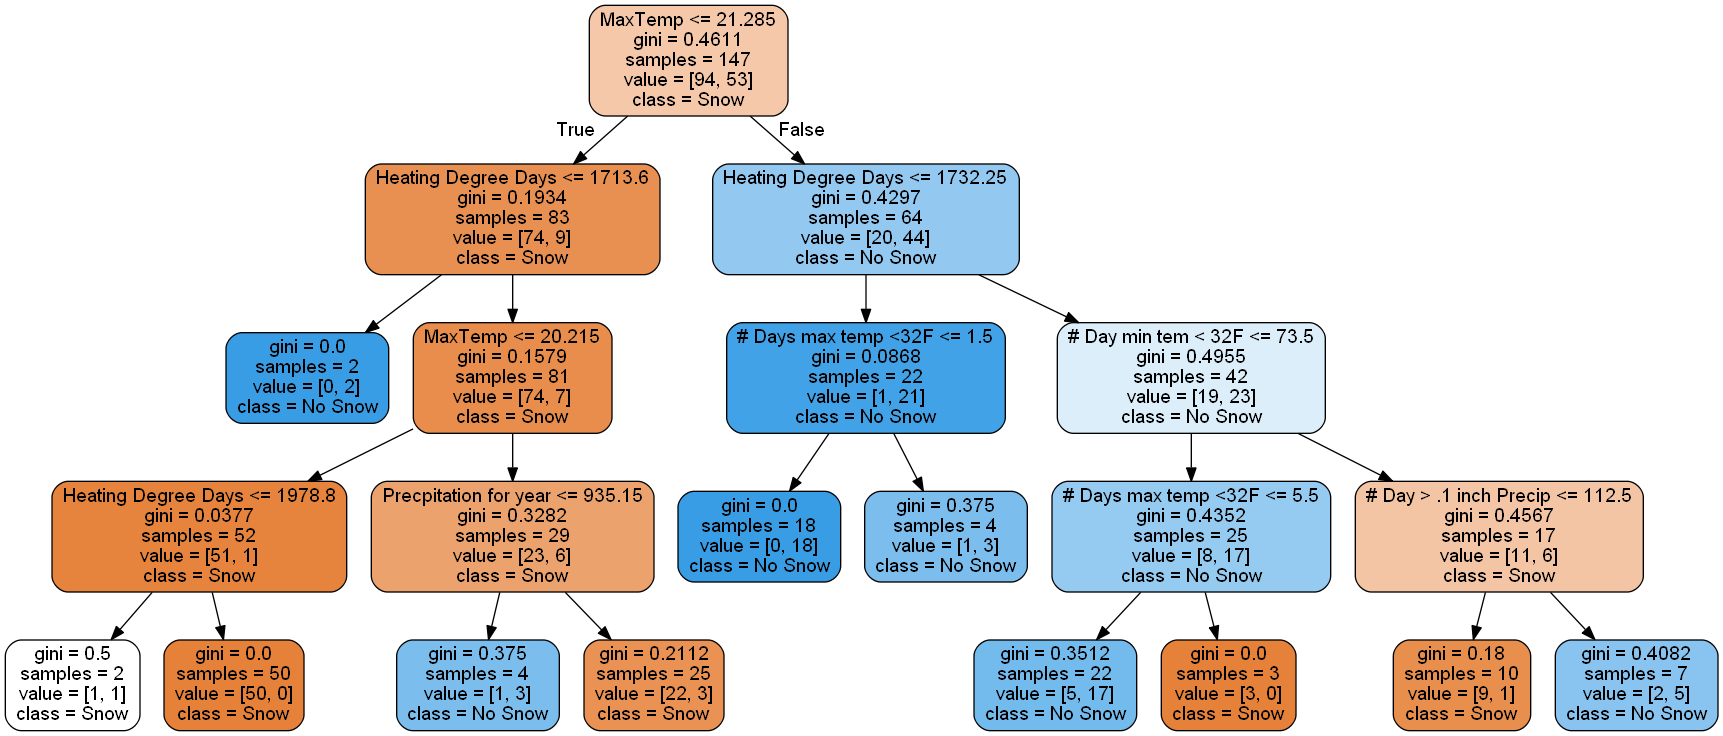

In [73]:
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=labels, class_names=targets, filled=True, rounded=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
#graph.write_pdf("C:/Programming/Analyses/Weather Data/Datasets/Outcomes/RDU_snow.pdf") 
display(Image(graph.create_png()))

In [74]:
importance=dt.feature_importances_


importance_df=pd.DataFrame({
        'Variable': labels,
        'Importance': importance     
        })
importance_df.sort_values(by='Importance', axis=0, ascending=False)

,Importance,Variable
4,0.553916,MaxTemp
5,0.195174,Heating Degree Days
2,0.077233,# Days max temp <32F
7,0.067383,# Day > .1 inch Precip
11,0.059353,Precpitation for year
9,0.046941,# Day min tem < 32F
0,0.000000,AVG Temp C
1,0.000000,Cooling Degree Days
3,0.000000,MinTemp
6,0.000000,# Days max>90F


### Random Forest

In [75]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, max_depth=5)
rf.fit(X_train, Y_train)

valid_rf_pred=rf.predict(X_valid)

validation_matrix=confusion_matrix(Y_valid, valid_rf_pred)
accuracyn=100*round(accuracy_score(Y_valid, valid_rf_pred),3)

print(validation_matrix, "Confusion Matrix RF")
print(accuracy, "Accuracy RF")

oob_error=rf.oob_score_  #Lists accuracy, 1-oob = misclassification
print(100*round(oob_error,3), "Accuracy of model - RF OOB")

[[30 10]
 [ 6 17]] Confusion Matrix RF
76.2 Accuracy RF
78.9 Accuracy of model - RF OOB


### Gradient Boost

In [76]:
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)

valid_gb_pred=gb.predict(X_valid)

validation_matrix=confusion_matrix(Y_valid, valid_gb_pred)
accuracy=100*round(accuracy_score(Y_valid, valid_gb_pred),3)

print(validation_matrix, "Confusion Matrix GB")
print(accuracy, "Accuracy GB")

[[30 10]
 [ 7 16]] Confusion Matrix GB
73.0 Accuracy GB


### Logistic Regression

In [77]:
lm = LogisticRegression(C=1)
lm.fit(X_train, Y_train)

valid_lm_pred=lm.predict(X_valid)

accuracy=100*round(accuracy_score(Y_valid, valid_lm_pred),3)
validation_matrix=confusion_matrix(Y_valid, valid_lm_pred)

print(validation_matrix, "Confusion Matrix LM")
print(accuracy, "Accuracy LM")


[[30 10]
 [ 6 17]] Confusion Matrix LM
74.6 Accuracy LM


### SVM

In [ ]:
sv_m = SVC(kernel='poly')
sv_m.fit(X_train, Y_train)

valid_svm_pred=sv_m.predict(X_valid)

validation_matrix=confusion_matrix(Y_valid, valid_svm_pred)
accuracy=100*round(accuracy_score(Y_valid, valid_svm_pred),3)

print(validation_matrix, "Confusion Matrix SVM")
print(accuracy, "Accuracy SVM")